In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

In [73]:
connection = sqlite3.connect("./Data/db2assign2.db")
cursor = connection.cursor()

In [74]:
# Read in csv data
dept_df = pd.read_csv('./Data/Department_Information.csv').to_sql("deptInfo", connection, if_exists='replace', index=True)
emp_df = pd.read_csv('./Data/Employee_Information.csv').to_sql("employInfo", connection, if_exists='replace', index=True)
counsel_df = pd.read_csv('./Data/Student_Counceling_Information.csv').to_sql("studentCounselling", connection, if_exists='replace', index=True)
perf_df = pd.read_csv('./Data/Student_Performance_Data.csv').to_sql("studentPerformance", connection, if_exists='replace', index=True)




In [94]:
df1 = pd.read_sql_query("SELECT * FROM deptInfo", connection)
df2 = pd.read_sql_query("SELECT Effort_Hours, Marks FROM studentPerformance", connection)

<AxesSubplot: title={'center': 'Plot of Effort/Mark achieved'}, xlabel='Marks', ylabel='Effort_Hours'>

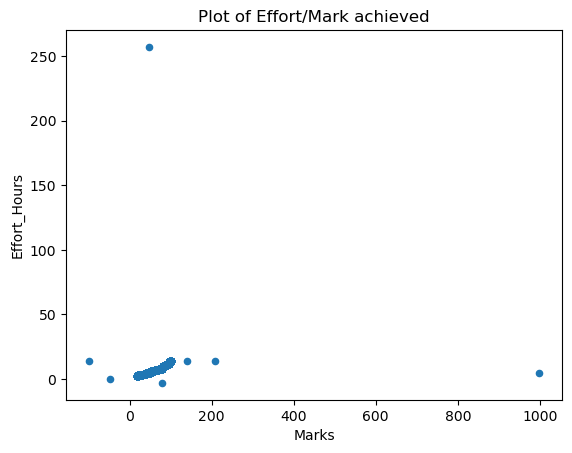

In [82]:
df2.plot.scatter(x='Marks', y='Effort_Hours', title='Plot of Effort/Mark achieved')

In [91]:
# print(df2.corr())
# anything above 0.8 is considered 'high' according to LinRegmin
# we can use this loop to test any two column dataframe for correlations
corrTest = df2.corr()
for col1 in corrTest.columns:
    for col2 in corrTest.columns:
        if col1 != col2 and abs(corrTest.loc[col1, col2]) > 0.8:
            print(f"{col1} vs {col2}: {corrTest.loc[col1, col2]:.3f}")

Effort_Hours vs Marks: 0.940
Marks vs Effort_Hours: 0.940


In [112]:
# This takes a dataframe with numerical entries and groups them together
# SHOULD work with multiple columns?
def print_correlations(dataf, threshold):
    corr_test = dataf.corr(numeric_only=True)
    checked = set()

    for col1 in corr_test.columns:
        for col2 in corr_test.columns:
            if col1 != col2 and (col2, col1) not in checked:
                correlation = corr_test.loc[col1, col2]
                if abs(correlation) > threshold:
                    print(f"[{col1}:{col2}:{correlation:.3f}]")
                checked.add((col1, col2))
print(print_correlations(df2,0.8))

[Effort_Hours:Marks:0.940]
None


In [102]:
def log_exception(df, name):
    if not df.empty:
        exceptions[name] = df
        print(f"[!] {len(df)} issue(s) found in {name}")
    else: 
        print(f"[OK] {name} - no issues found")

In [61]:
log_exception(dept_df, 'Department_ID')

AttributeError: 'int' object has no attribute 'empty'

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().